In [112]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap
import geopandas
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
#import geoplot
#import shapefile as shp

from sklearn.linear_model import LinearRegression, LogisticRegression
from VendorsParsingTools import *
from ForumParsingTools import *
from ProductListingParsingTools import *
from libs.milestone2Methods import *
import geopandas
import descartes
import geoplot
import shapefile as shp
import warnings; warnings.simplefilter('ignore')

# 1) General overview

## 1.0) Used datasets

###  agora

  - ##### Description
  The archive contains scraped html pages from the market's Vendor profiles, Listings, Category Lists, Listing pictures and User profiles. Only the Vendor profiles and the Category List of items were used.



###  agora-forums

  - ##### Description
  The archive contains scraped html pages from the forum's global stats, the topics, the topic list per board. Only the global stats and the topic lists per board were used.


###  grams

  - ##### Description
  The archive contains csv files of requests results obtained on the Grams platform for several services, a search engine for the DarkNet marketplaces. Only the results related to Agora were used.



### [_DNStats_](https://dnstats.net/)
  - #### Description
  The archive contains a single sql files containing the measured ping, http response, and other information made by the DNStats platform over almost 3 years for nearly all DarkNet services. It was promptly pared to retain only the requests made to Agora and Agora-Forum.

## 1.1) Files obtained for each day

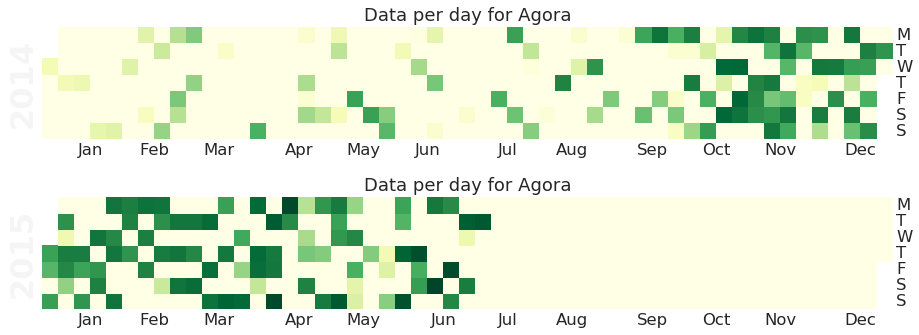

In [113]:
agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')
all_days_df = generateFileCount(forum_df, agora_df)
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

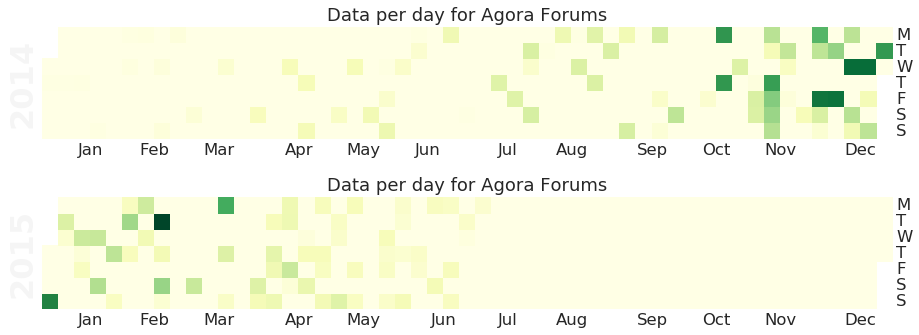

In [114]:
calmap.calendarplot(events_for,daylabels='MTWTFSS',cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0,fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora Forums'});

>This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum. There is no stable web scrapping of both websites. In order to understand better this problem, we will study the uptime average of both services in the next part.

## 1.2) Services Uptime

> We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora depending on the uptime of the sercices, or even see if the Onymous operation had an impact on the services uptime. 


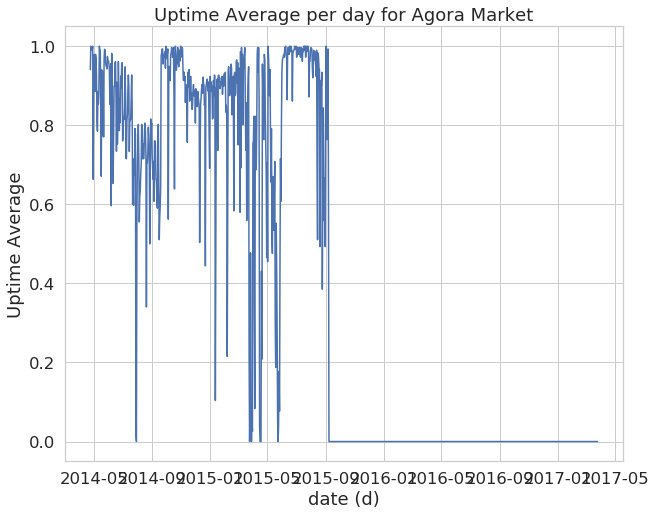

In [115]:
agora_df1 = pd.read_csv('../data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
forum_subdf1 = agora_df1[agora_df1['sitename'] == "Agora Forums"]

agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
forum_subdf1 = forum_subdf1.groupby(by='timestamp').mean()

def plotUptime(x, y, title):
    fig, ax1 = plt.subplots( figsize=(10,8))
    ax1.set_xlabel('date (d)')
    ax1.set_ylabel('Uptime Average')
    ax1.plot(x, y)
    ax1.tick_params(axis='y')
    plt.title(title)
    plt.show()
    
plotUptime(agora_subdf1.index, agora_subdf1['siteup'], 'Uptime Average per day for Agora Market')

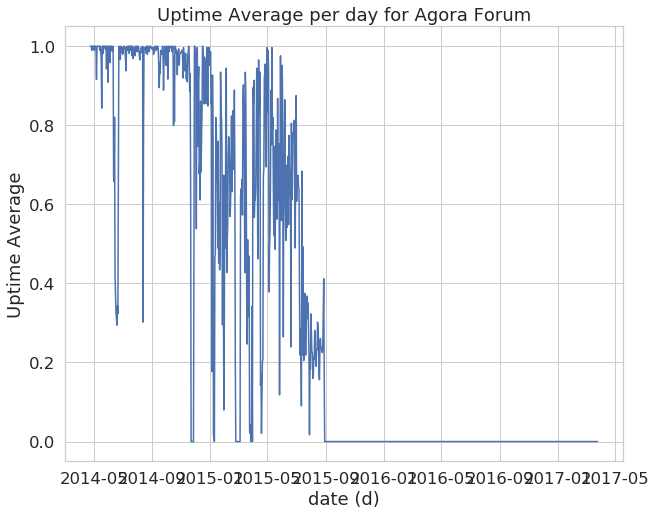

In [116]:
plotUptime(forum_subdf1.index, forum_subdf1['siteup'], 'Uptime Average per day for Agora Forum')

> We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum. It made the webscrapping quite difficult to do, we have to expect a lot of missing data. Now let's take a look just before and after the Onymous operation: 

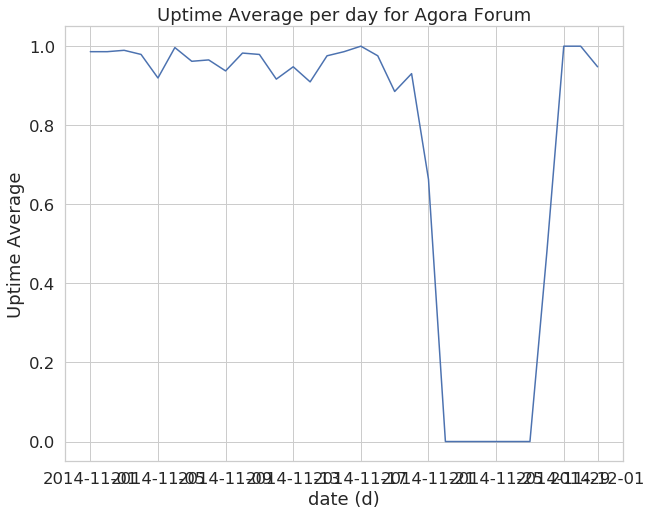

In [117]:
date_range = pd.date_range(start='2014-11-01', end='2014-12-01', freq='D')
plotUptime(forum_subdf1.loc[date_range].index, forum_subdf1['siteup'][date_range], 'Uptime Average per day for Agora Forum')

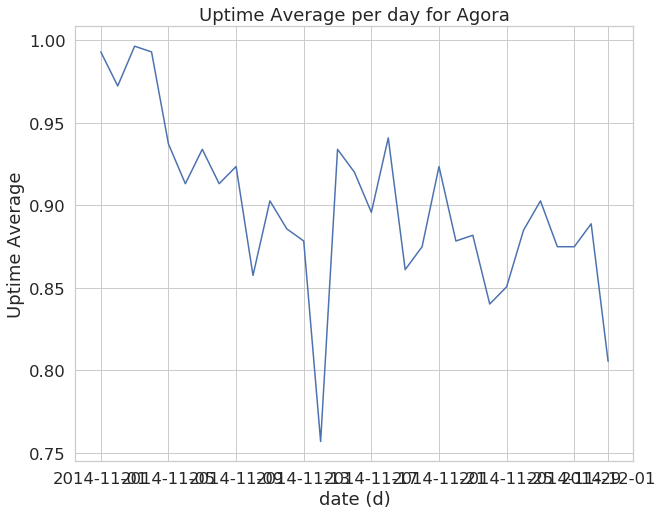

In [118]:
plotUptime(agora_subdf1.loc[date_range].index, agora_subdf1['siteup'][date_range], 'Uptime Average per day for Agora')

Take a look at the period of Operation Onymous and see that there is a fall in the uptime average shortly after both for market and forum, but not at the same time. We also observe that shortly after the drop, the uptime average is back to normal for the forum and it has increased for the market but it tends to slow down.

## 1.3) Unusable Files

# 2) Forum Analysis

In [119]:
forumDF = pd.read_csv('../saved_gen_df/nPages_nTopicest_nSample_perDayAndBoard.csv')
filtered_df = pd.read_csv('../saved_gen_df/forum_filtered_df.csv')
forum_stats = pd.read_csv('../saved_gen_df/forum_stats_df.csv')

In [120]:
#forum_stats.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'],inplace=True)
filtered_df.drop(columns=['tokens'],inplace=True)

filtered_df['board'] = filtered_df['board'].astype(str)

In [121]:
def word_extract(x):
    words = []
    # Loop over the words in the title
    for i in x:
        words.append(i)

    return words

In [122]:
filtered_df.head()

date                                       board        author  \
0  2014-01-02  ('General Category', 'General Discussion')      Scarface   
1  2014-01-02  ('General Category', 'General Discussion')     Manlyness   
2  2014-01-02  ('General Category', 'General Discussion')       maligan   
3  2014-01-02  ('General Category', 'General Discussion')  Mangling2012   
4  2014-01-02  ('General Category', 'General Discussion')       stannis   

   nReplies  nViews                        lastPost            clean_title  \
0         8     106  December 23, 2013, 07:08:51 am        become  vendor    
1         1      31  December 23, 2013, 04:35:33 am          buyer account   
2         2      49  December 23, 2013, 04:23:34 am              sign        
3         0      17  December 23, 2013, 04:03:37 am  hello hello  good       
4         3      89  December 23, 2013, 02:51:52 am    marketplace invite    

              tokens_filtered  
0         ['becom', 'vendor']  
1        ['buyer', 'account']  
2                    ['sign']  
3  ['hello', 'hello', 'good']  
4     ['marketplac', 'invit']

In [123]:
#Selection of boards to look into
boards_bf = np.array(["('General Category', 'Vendor Discussion')",
       "('General Category', 'Newbie Section ')",
       "('General Category', 'Referral Links')",
       "('General Category', 'Security Discussion')"])

In [124]:
# Sub-set for the 4 months preceeding the Onymous event
subdf_bef = filtered_df[(filtered_df['date'] >= '2014-07-05') & (filtered_df['date'] <= '2014-11-06')
                       & (filtered_df['board'].isin(boards_bf))]
# Sub-set for the month following the Onymous event
subdf_af = filtered_df[(filtered_df['date'] >= '2014-11-07') & (filtered_df['date'] <= '2014-12-07')
                      & (filtered_df['board'].isin(boards_bf))]

In [ ]:
all_words_bf = sum(word_extract(subdf_bef['tokens_filtered']), [])
all_words_af = sum(word_extract(subdf_af['tokens_filtered']), [])

In [ ]:
a = nltk.FreqDist(all_words_bf)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d[5:], x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
a = nltk.FreqDist(all_words_af)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 25)
print(d[3:])
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d[5:], x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Forum activity

In addition to the faulty sampling itself, the global activity on the forum seems to be quite eventful, considering several significant content but mostly a high production rate.

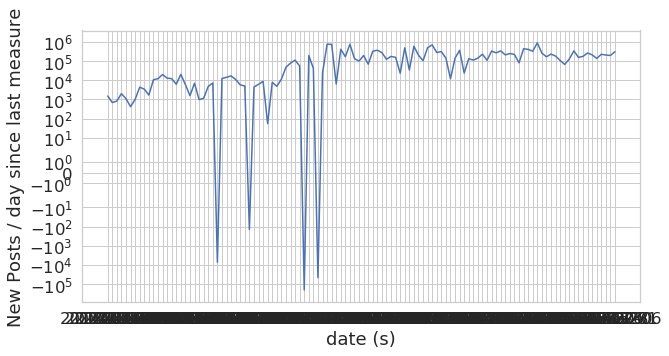

In [126]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Posts / day since last measure')
ax1.plot(forum_stats['date'], forum_stats['new_posts'])
ax1.tick_params(axis='y')

plt.yscale('symlog')
plt.show()

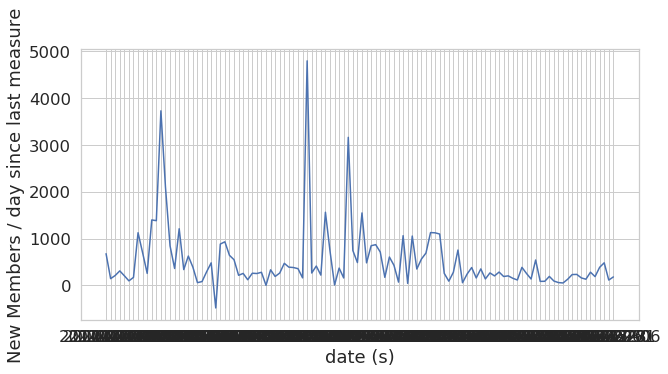

In [127]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Members / day since last measure')
ax1.plot(forum_stats['date'], forum_stats['new_members'])
ax1.tick_params(axis='y')

plt.show()

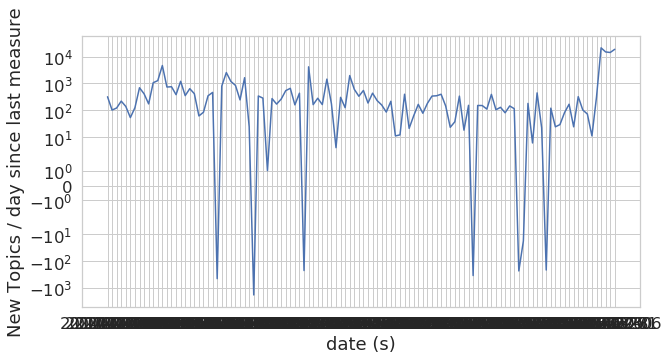

In [128]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Topics / day since last measure')
ax1.plot(forum_stats['date'], forum_stats['new_topics'])
plt.yscale('symlog')

plt.show()

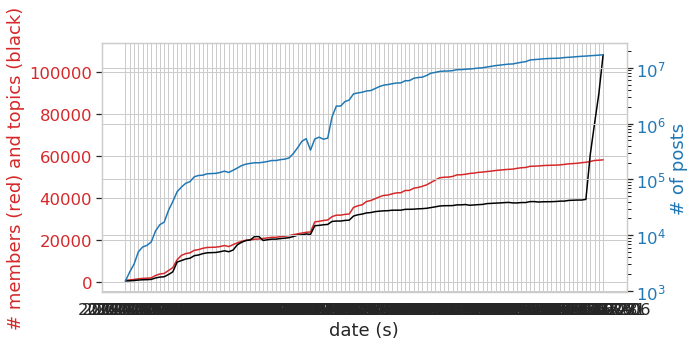

In [129]:
# Plot the number of members (red), of topics (black) and of posts (blue) over time
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('date (s)')
ax1.set_ylabel('# members (red) and topics (black)', color=color)
ax1.plot(forum_stats['date'], forum_stats['members'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(forum_stats['date'], forum_stats['topics'], color='black')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of posts', color=color)  # we already handled the x-label with ax1
ax2.plot(forum_stats['date'], forum_stats['posts'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yscale('log')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [130]:
forum_stats[forum_stats['new_posts'] < 0]
# Show that posts were removed on those particular days

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  members  \
24          24            24              24                24    16716   
31          31            31              31                31    20317   
43          43            43              43                43    23664   
46          46            46              46                46    29143   

     posts  topics  nOnline        date  new_posts  days_elapsed  new_members  \
24  132894   14246        5  2014-06-10    -7243.0           1.0       -482.0   
31  198093   21485        5  2014-08-02     -142.0           3.0        121.0   
43  334265   22495        5  2014-09-28  -201673.0           2.0        161.0   
46  523840   27080        5  2014-11-21   -46268.0           2.0        414.0   

    new_topics  
24      -460.0  
31        24.0  
43      -229.0  
46       279.0

In [131]:
forum_stats[forum_stats['new_members'] < 0]
# Show that members were removed this days precisely

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  members  \
24          24            24              24                24    16716   

     posts  topics  nOnline        date  new_posts  days_elapsed  new_members  \
24  132894   14246        5  2014-06-10    -7243.0           1.0       -482.0   

    new_topics  
24      -460.0

In [132]:
forum_stats[forum_stats['new_topics'] < 0]
# Show that topics were removed on those particular days

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  members  \
24          24            24              24                24    16716   
32          32            32              32                32    20577   
43          43            43              43                43    23664   
80          80            80              80                80    51523   
90          90            90              90                90    53589   
91          91            91              91                91    53975   
96          96            96              96                96    55084   

       posts  topics  nOnline        date  new_posts  days_elapsed  \
24    132894   14246        5  2014-06-10    -7243.0           1.0   
32    202565   19623        5  2014-08-05     4472.0           3.0   
43    334265   22495        5  2014-09-28  -201673.0           2.0   
80   9510546   36372        5  2015-04-14   112282.0           1.0   
90  11693038   37503        5  2015-05-10    81219.0           4.0   
91  12132780   37485        5  2015-05-11   439742.0           1.0   
96  14186943   37915        5  2015-05-29   167278.0           1.0   

    new_members  new_topics  
24       -482.0      -460.0  
32        260.0     -1862.0  
43        161.0      -229.0  
80        382.0      -352.0  
90        116.0      -237.0  
91        386.0       -18.0  
96         88.0      -219.0

### Sample vs Estimated Number of Topics Visualization

In [133]:
px.scatter(forumDF, x="nTopics_est", y="nSample", animation_frame="date", animation_group="board",
           size='nPages', size_max=55, color="board", hover_name="board",
          range_x=[1, 30000], range_y=[1,30000], log_x=True, log_y=True)

In the map visible[here](https://github.com/ADA-2019/Project/tree/master/scripts/file.html) we can see that the number of sampled topics is always very low compared to the actual number. However, given that the limited sampled topics are generally the most recent ones, there still could be some insight to gain there.

# 3) Market Analysis

## 3.1) Data Enrichment

In [134]:
price_df = pd.read_csv('../saved_gen_df/prices_and_stuff.csv')
price_df = price_df.drop(columns=['mean', 'std', 'min', '25%', '75%'])

In [135]:
# From the Grams archive, listings were parsed and we only kept the sampling date and the number of listing
#             for every country
price_df

filename                 ship_from  count       50%       max
0      2014-06-09                 Argentina   18.0  0.000000  0.000000
1      2014-06-09                 Australia  592.0  0.000000  0.000000
2      2014-06-09                   Austria   11.0  0.000000  0.000000
3      2014-06-09                   Belgium   66.0  0.000000  0.000000
4      2014-06-09                    Brazil    2.0  0.000000  0.000000
...           ...                       ...    ...       ...       ...
14514  2015-07-12                  bluerave  137.0  0.003000  0.150000
14515  2015-07-12            United Kingdom    4.0  0.249186  0.614932
14516  2015-07-12  United States of America    2.0  0.282305  0.282305
14517  2015-07-12                     world    1.0  0.090443  0.090443
14518  2015-07-12                 worldwide    3.0  0.033766  0.037484

[14519 rows x 5 columns]

In [136]:
# Get world map
world = geopandas.read_file(
    geoplot.datasets.get_path('world')
)
sf = shp.Reader('../data/ne_50m_admin_0_countries.shp')
world_df = read_shapefile(sf)

In [137]:
# Merge using the country names as index
world_df = world_df[['NAME', 'CONTINENT']]
world_df.rename(columns={'NAME':'name'}, inplace=True)
world_df = pd.merge(world, world_df, how='inner')

In [138]:
world_df['count'] = 0
world_df['continent_count'] = 0

In [139]:
# Create map filling count for a given sample 
DATE = "2015-07-12"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

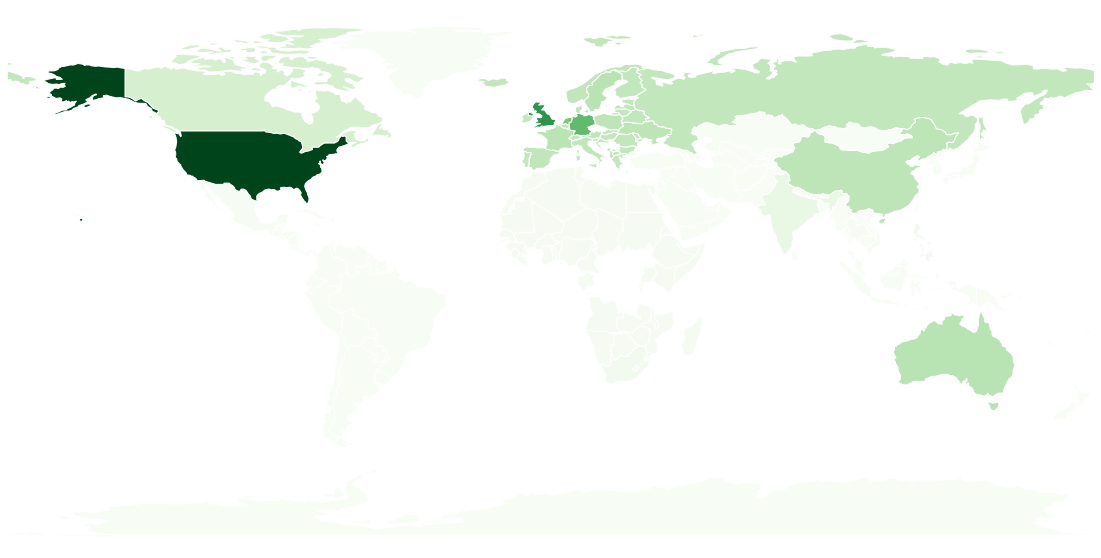

In [140]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));

We clearly can see that some areas are more populated than others, this angle could then possibly provide insightful information when studying the market.

## 3.3) Vendors Insight

In [141]:
vendorsDF = pd.read_csv('../saved_gen_df/vendorsDF_lastSeen_country_df.csv').drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])

In [142]:
vendorsDF.head(10)

name  rating    lastSeen  #products    #Deals parsingDate  \
0      littlegoblin   4.920  2014-09-19       14.0   150~200  2014-09-20   
1    Rebel_Alliance   4.990  2014-09-19        7.0   300~500  2014-09-20   
2     ThePartyDepot   5.000  2014-09-19        3.0    70~100  2014-09-20   
3          cossacks   4.990  2014-09-19        7.0   300~500  2014-09-20   
4        checkpoint   4.840  2014-09-19       31.0     55~70  2014-09-20   
5    GermanTerminal   4.994  2014-09-19       37.0  500~1000  2014-09-20   
6               AGP   4.910  2014-09-18        2.0    70~100  2014-09-20   
7       Top_Gear_UK   4.830  2014-09-19       21.0  500~1000  2014-09-20   
8  onefamilyonelove     NaN  2014-09-19        4.0         0  2014-09-20   
9            xinhai   4.974  2014-09-20       10.0     1000+  2014-09-20   

     country  
0         EU  
1     Canada  
2  Australia  
3         UK  
4    Belgium  
5    Germany  
6  Australia  
7         UK  
8        USA  
9        USA

We remove the date were the number of vendors is inferior to 150 since they are obviously consequence of a technical problem


In [143]:
nbVendorbyDate = vendorsDF[['parsingDate', 'name']].groupby(['parsingDate']).agg([ 'count'])
nbVendorbyDate = nbVendorbyDate[nbVendorbyDate[('name', 'count')] >150]

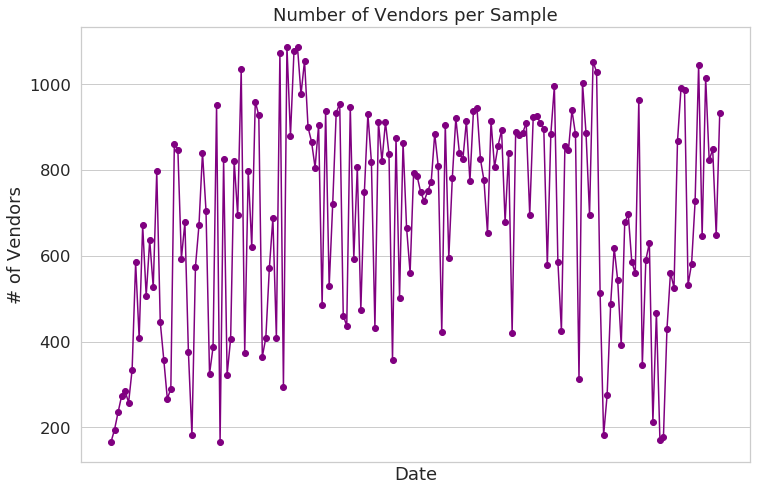

In [144]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(nbVendorbyDate.index,
        nbVendorbyDate[('name', 'count')],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of Vendors",
       title="Number of Vendors per Sample")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

Clearly, we see that this measure is not exploitable like this, vendor data will need to be enriched to obtain a significant representation of their population.

### Number of listing per Vendor

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24963f4ef0>]],
      dtype=object)

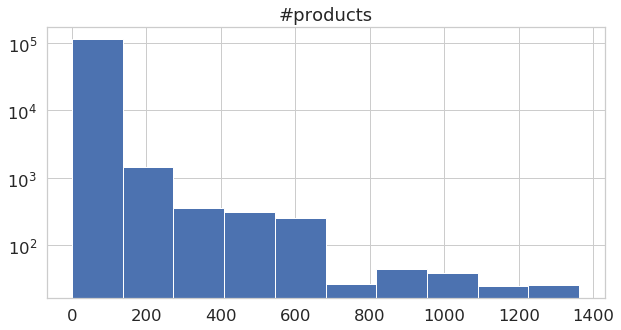

In [145]:
vendorsDF.hist(column='#products',log=True,figsize=(10,5))

This plot shows the huge variation inn the number of products sold by vendors. That means studying this feature might be insightful in order to understand the state of the market and the vendor population.

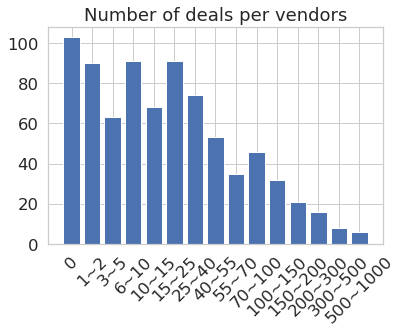

In [146]:
sortedStats = createStatsAboutNumbOfDeals(Counter(vendors['#Deals']))
plt.bar(sortedStats.keys(),sortedStats.values());
plt.xticks(rotation=45);
plt.title('Number of deals per vendors');

## 3.4) Listing insight

In this section, we will try to understand all the products listed in agora-market that we managed to retrieve.

In [147]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("../data/cat_csv/*.csv")
df.count()

2805212

So in total we have 2805212 products, we selected the following features: 

In [148]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- from: string (nullable = true)
 |-- to: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- cat_hash: string (nullable = true)
 |-- cat: string (nullable = true)
 |-- date: string (nullable = true)



> After some analysis, we cleaned the data as follow: 

In [149]:
def processCountries(country):
    # Remove html tags
    cleanr = re.compile('<.*?>')
    cleanText = str(re.sub(cleanr, '', str(country)))
    
    # Remove spaces
    cleanText = cleanText.strip(' ')
    
    # Remove ""
    cleanText = cleanText.strip('"')
    
    # Split for each country
    cleanText = re.split("&|,|/", cleanText)
    
    return cleanText

udf_func_C = udf(processCountries, ArrayType(StringType()))

def processCatHashs(cat_hash):
    # Remove html end of files
    cleanr = re.compile('.\d*.html')
    cleanText = str(re.sub(cleanr, '', str(cat_hash)))
    return cleanText

udf_func_H = udf(processCatHashs, StringType())

# Remove rows without a valid date, error during parsing, file not complete
df = df.filter(df["date"].rlike("\d\d\d\d-\d\d-\d\d"))

# Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
df = df.filter("CAST(price AS DECIMAL) is not null")

# Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
df = df.filter("name is not null")

# Lowercase and process the countries
df=df.withColumn("to", lower(col("to")))
df=df.withColumn("to", udf_func_C(col("to")))

# Lowercase and process the countries
df=df.withColumn("from", lower(col("from")))
df=df.withColumn("from", udf_func_C(col("from")))

# Process the hashs
df=df.withColumn("cat_hash", udf_func_H(col("cat_hash")))

> Once our data cleaned, we wanted to know if the number of listing per day parsed was consistent

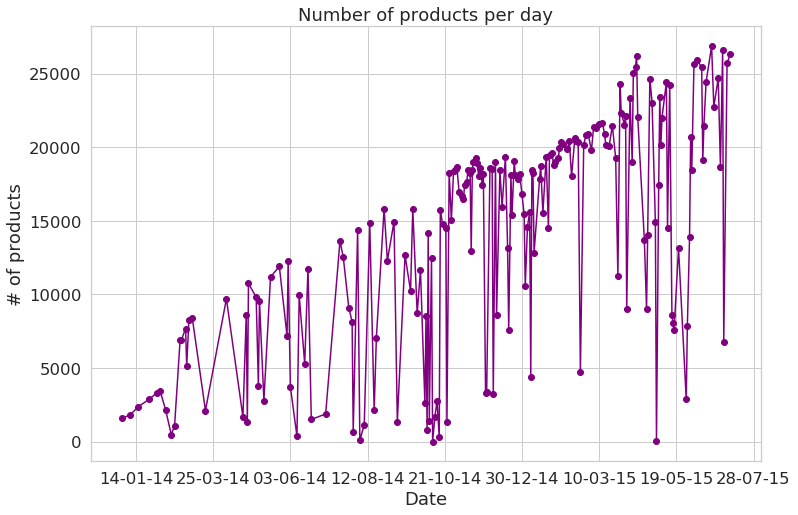

In [150]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

pdDF = df.groupby("date").agg(count("date")).toPandas()
pdDF = pdDF[pdDF['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
pdDF['date'] = pd.to_datetime(pdDF['date'],infer_datetime_format=True) 
pdDF = pdDF.sort_values(by='date', ascending=True, na_position='first')

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pdDF['date'],
        pdDF['count(date)'],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of products",
       title="Number of products per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

> We can see here that we have a lot of missing values, the number of products increase linearly but it drop a lot unpredictably

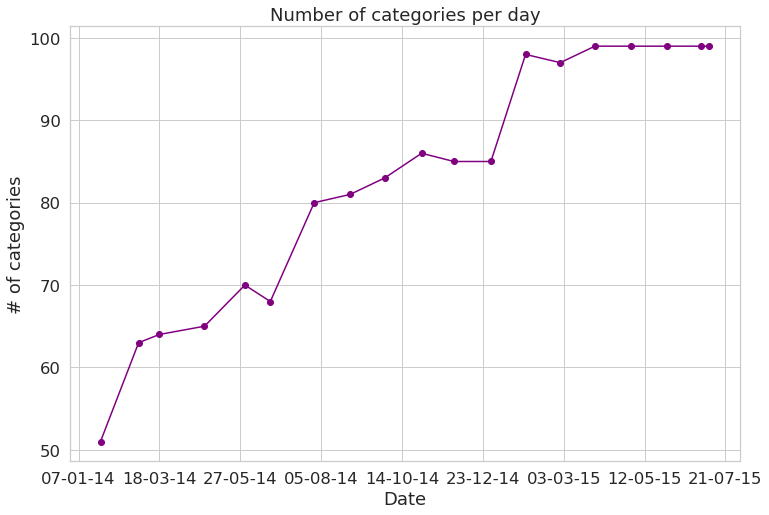

In [151]:
categories_per_day = df.groupby("date", "cat_hash").agg(count("cat_hash")).groupby("date").agg(count("cat_hash")).toPandas()
categories_per_day = categories_per_day[categories_per_day['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
categories_per_day['date'] = pd.to_datetime(categories_per_day['date'],infer_datetime_format=True) 
categories_per_day = categories_per_day.sort_values(by='date', ascending=True, na_position='first')
categories_per_day = categories_per_day.rename(columns={'count(cat_hash)': 'catNumber'})

max_categories_per_day = categories_per_day.groupby([categories_per_day.date.dt.month, categories_per_day.date.dt.year]).max()
max_categories_per_day = max_categories_per_day.reset_index(drop=True)
max_categories_per_day = max_categories_per_day.sort_values(by='date', ascending=True, na_position='first')

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(max_categories_per_day['date'],
        max_categories_per_day['catNumber'],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of categories",
       title="Number of categories per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()


> We can see here that if we pick one day per month with the maximum number of categories parsed, the result seems more predictable than before, it could be a solution to our missing data problem. We still need to dig a bit into different solution in order to plot the correct # of products or categories by day. 

# 4) Plan

##  4.1) Research questions

Due to the large amount of time needed to process the data and handle missing data, we will restrict a bit our research questions : 

* How did it affect the global sales on a short and a longer timescale ?
* How was the user traffic affected ?
* How was the "online traffic" popularity affected ?
* Were there any trends in the forums during this kind of intervention ?
* How did the prices evolve globally ?




## 4.2) Potential issues

The main issues of this project are caused by the missing data, it is very complicated to give meaningful information when we cannot be certain that we cover all the services.

## 4.3) Plannification

  - #### Dec 2th
  Data enrichment 
  Depth analysis of the data.
  Answer research questions.
  - #### Dec 9th
  Create meaningful vizualisation for the results.
  Put all together in a beautiful data story.
  - #### Dec 17th
  Finish producing content for the data story.

  ***
  - #### Dec 20th DEADLINE
  Finalize the data story for submission.
  ***